## Exercise: Introduction to pm4py

***You are hired by an ecommerce company to perform some simple business analysis tasks and help the company. Remembering your knowledge from the course, you know that you can apply the `pm4py` package to execute the business analysis quickly.***

This jupyter notebook contains some exercises to make you familiar with the process mining package `pm4py` and motivate its use through some practical hands-on examples. This way, you will easily be able to apply your learned knowledge in practice. If you struggle with some exercises, we recommend you to look at our **Demo Project: Introduction to pm4py** and use the [official documentation](https://processintelligence.solutions/static/api/2.7.11/pm4py.html).

In [1]:
# Necessary imports for the remainder of the notebook
import pm4py
import pm4py.objects.petri_net.importer
import pandas as pd

pd.options.mode.chained_assignment = None  # default='warn', suppress warnings when importing logs from https://www.ocel-standard.org/event-logs/

---

### Exercise 1: Importing the event log

***The company collected some data about its real-world process in an object-centric event log. Use the log to solve the following exercises.***

To apply process mining algorithms, we firstly need to import an event log. Common data extensions are `.xes`, `.csv`, and `.sqlite`. For that purpose, import the object-centric event log given by `ecommerce_cleaned.sqlite` and save it in the variable `ocel`.

In [2]:
ocel = pm4py.read_ocel2_sqlite("./event-logs/ecommerce_cleaned.sqlite")
print(f'\n{ocel}')

/home/jan/.local/share/virtualenvs/hiwijob-PM4PY-3kBpM2sT/lib/python3.11/site-packages/pm4py/objects/ocel/importer/sqlite/variants/ocel20.py:70: UserWarning: There are unsatisfied OCEL 2.0 constraints in the given relational database: ['const_14_primary_key_object_event_map_type_tables', 'const_15_primary_key_object_event_tables', 'const_16_primary_key_event_object_table', 'const_17_primary_key_object_object_table', 'const_18_primary_key_event_type_spec_tables', 'const_19_foreign_key_event', 'const_20_foreign_key_object', 'const_21_foreign_key_event_object', 'const_22_foreign_key_object_object', 'const_23_foreign_key_event_type_specific', 'const_24_foreign_key_object_type_specific']
  warnings.warn("There are unsatisfied OCEL 2.0 constraints in the given relational database: "+str(unsatisfied))



Object-Centric Event Log (number of events: 14066, number of objects: 6574, number of activities: 16, number of object types: 4, events-objects relationships: 35592)
Activities occurrences: {'add item': 3998, 'logout': 1247, 'register': 1118, 'login': 1118, 'prepare delivery': 729, 'create order': 717, 'select shipping': 717, 'place order': 717, 'send invoice': 717, 'pay': 572, 'confirm payment': 572, 'give to carrier': 511, 'carrier confirms': 489, 'delivered': 417, 'delivery': 417, 'cancel order': 10}
Object types occurrences (number of objects): {'item': 4010, 'customer': 1118, 'package': 729, 'order': 717}
Please use <THIS>.get_extended_table() to get a dataframe representation of the events related to the objects.


---

### Exercise 2: Objects

***The company wants you to extract some useful information about the objects from the given event log. Firstly, they want to know which object types are involved in their process and what the average prices of each object are. Specifically for the items, they want to know the specific item objects with the minimal price and maximal price.***

#### Exercise 2a: Object types

Now, we want to know which object types exist in the object-centric event log. Fill in the correct function that retunrs a list of all object types contained in the previously created variable `ocel`.

In [3]:
object_types = pm4py.ocel_get_object_types(ocel)
print(f'The following types of objects are contained in the log: {object_types}\n')

The following types of objects are contained in the log: ['customer', 'item', 'order', 'package']



#### Exercise 2b: Average object prices

For each object type in the event log, we want to compute its average price. To compute the average for a column, use the pandas `mean()` method.

In [4]:
average_prices = {}

for obj in object_types:
    objects_of_obj_type = ocel.objects[ocel.objects['ocel:type'] == obj]
    average_prices[obj] = objects_of_obj_type['price'].mean()
    
print(average_prices)

{'customer': nan, 'item': np.float64(225.5120060030015), 'order': nan, 'package': nan}


#### Exercise 2c: Cheapest and most expensive item

Lastly, determine the item that sold for the highest price and the item that sold for the lowest price. In addition to the item's `ocel:oid`, determine the item's `type` and `price`.

In [5]:
items = ocel.objects[ocel.objects['ocel:type'] == 'item']
cheapest_item = items[items['price'] == items['price'].min()]
most_expensive_item = items[items['price'] == items['price'].max()]

cheapest_item_name = cheapest_item.iloc[0]['ocel:oid']
cheapest_item_type = cheapest_item.iloc[0]['type']
cheapest_item_price = cheapest_item.iloc[0]['price']

most_expensive_item_name = most_expensive_item.iloc[0]['ocel:oid']
most_expensive_item_type = most_expensive_item.iloc[0]['type']
most_expensive_item_price = most_expensive_item.iloc[0]['price']

print(f'The cheapest item is {cheapest_item_name} of type {cheapest_item_type} at a price of {cheapest_item_price} USD.\n')
print(f'The most expensive item is {most_expensive_item_name} of type {most_expensive_item_type} at a price of {most_expensive_item_price} USD.\n')

The cheapest item is item67 of type Sunscreen at a price of 2.0 USD.

The most expensive item is item2416 of type Laptop at a price of 2989.0 USD.



---

### Exercise 3: Object-centric process models

***To get a better understanding of the real-world process executed by the company, the company wants to get a process model for its captured real-world behaviour. The communication process with the delivery carrier has already been optimized by the company recently, thus the company wants to ommit the related activities in the process model.***

#### Exercise 3a: Filtering

Create a `filtered_ocel` variable by removing the activities `give to carrier` and `carrier confirms` from the event log.

In [6]:
filtered_ocel = pm4py.algo.filtering.ocel.event_attributes.apply(ocel, ['give to carrier', 'carrier confirms'], {'positive': False})

#### Exexrcise 3b: Object-centric process discovery

Discover an object-centric Directly Follows Graph from the filtered event log. We assume that directly follows relations between activities that appear less than 250 times are not important enough to be considered by the process model. Create and visualize an OCDFG with the corresponding `edge_threshold`.

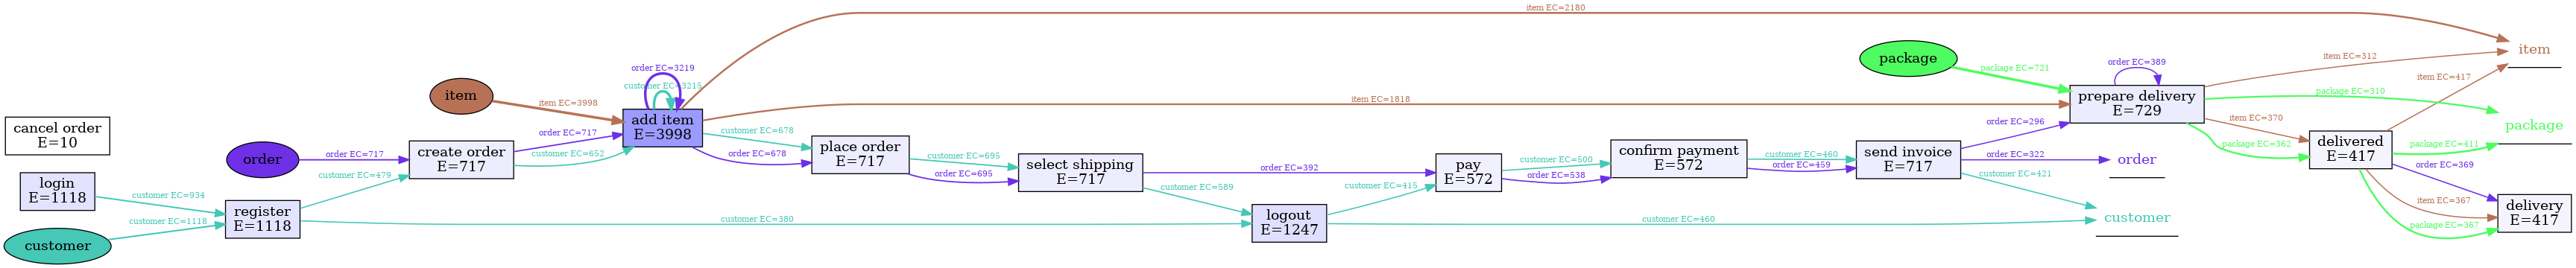

In [7]:
ocdfg = pm4py.discover_ocdfg(filtered_ocel)
pm4py.view_ocdfg(ocdfg, edge_threshold = 250)

---

### Exercise 4: Flattened process models

***To understand the process from the customer's perspective, another process model should be reflecting the interaction of customers with the process. The process model obtained from the event log should be compared to the currently used process model of the company. For this purpose, the company wants to know which of the process models fits the real-world behaviour more precisely.***

#### Exercise 4a: Flattening

Flatten the object-centric event log by `customer`.

In [8]:
event_log_customer = pm4py.ocel_flattening(ocel, 'customer')

#### Exercise 4b: Process discovery

In the lecture, you learned about the Inductive Miner to discover Petri nets from an event log. Apply the Inductive Miner with a `noise_threshold` of 0.3 to filter out uncommon behaviour and obtain a clearer process model. Visualize the discovered Petri net.

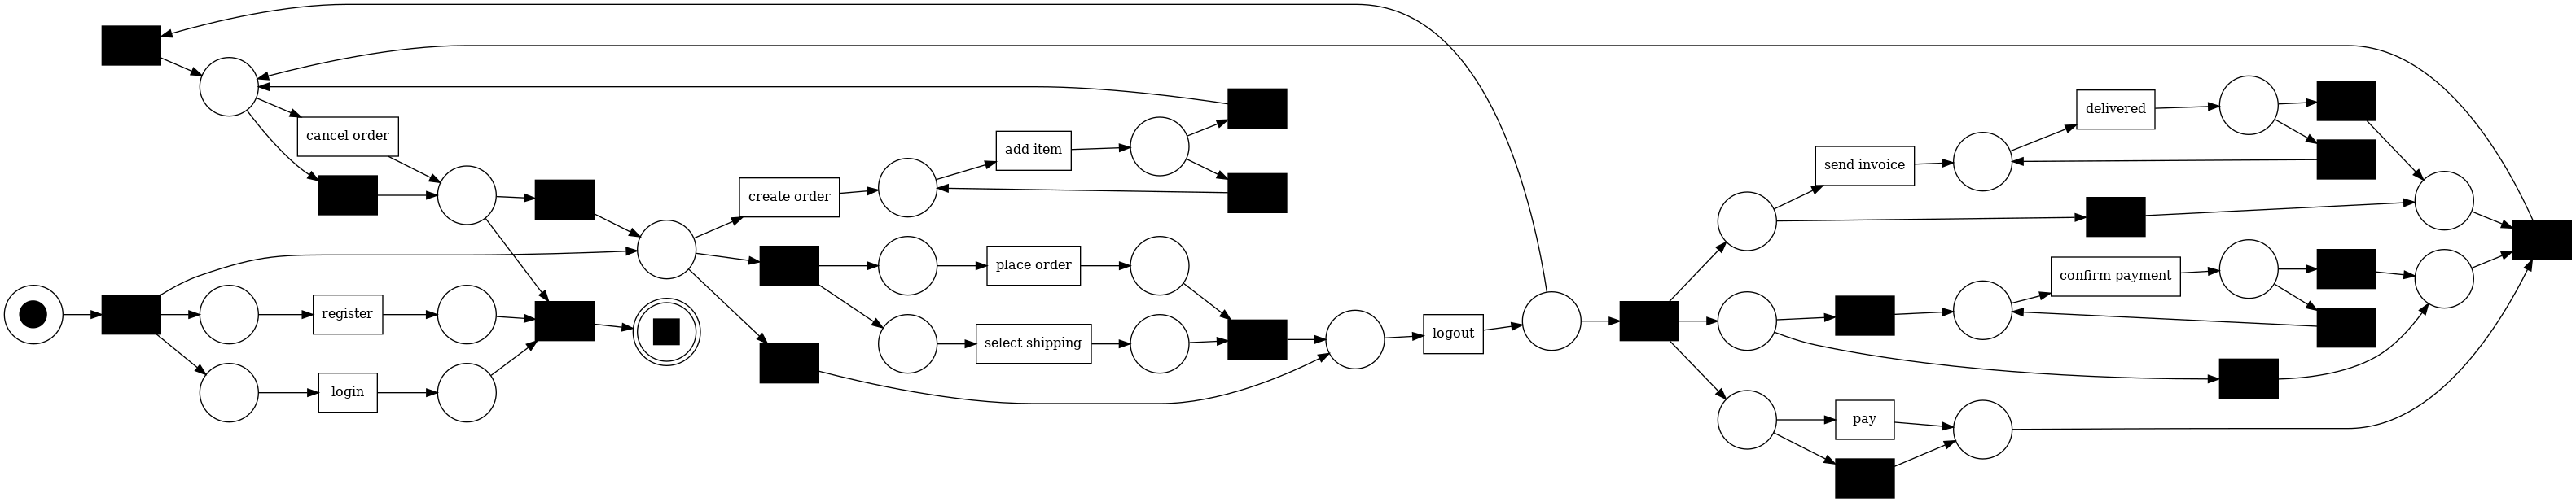

In [9]:
pnet, im, fm = pm4py.discover_petri_net_inductive(event_log_customer, noise_threshold=0.3)
pm4py.view_petri_net(pnet, im, fm)

#### Exercise 4c: Importing a process model

In the folder `event_logs` you can find a Petri net process model saved as `exercise_4c_pnet_hm99.pnml`. The company has discovered it using a Heuristic Miner. Import the Petri net and visualize it.

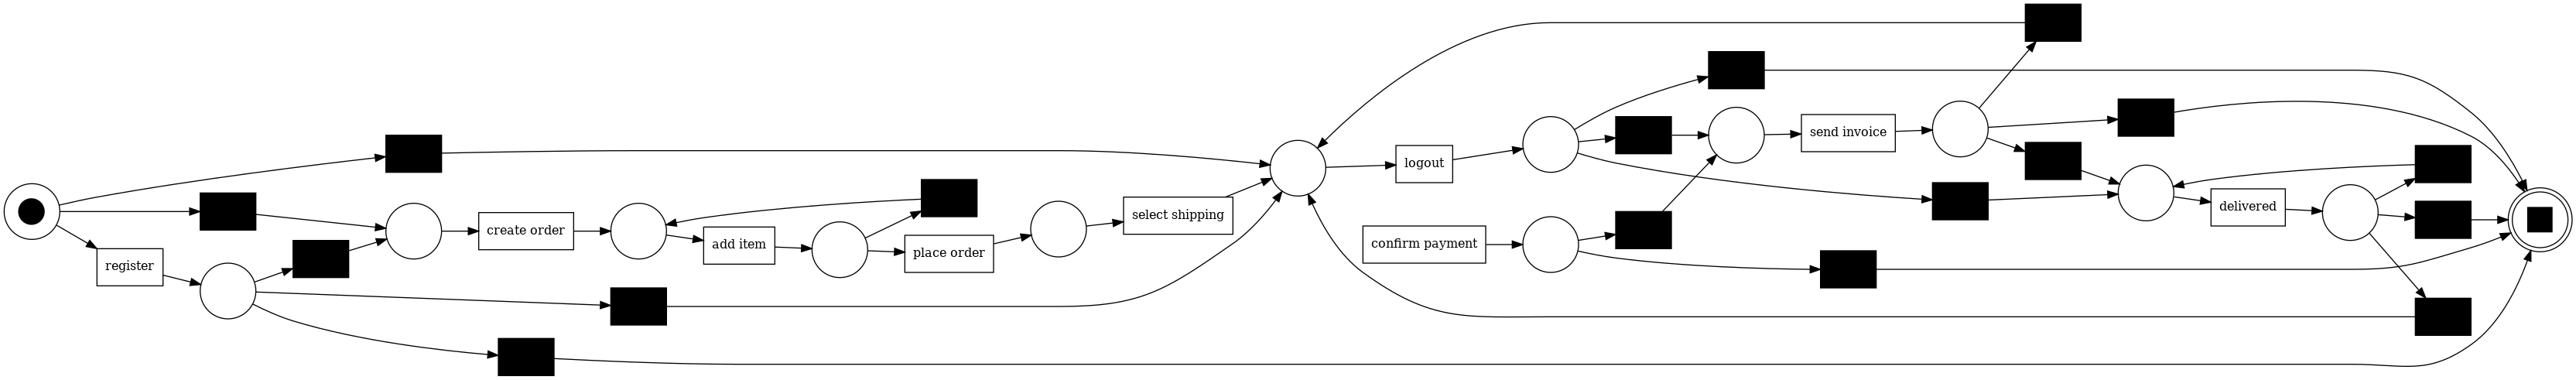

In [10]:
pnet_comp, im_comp, fm_comp = pm4py.objects.petri_net.importer.importer.apply('event-logs/exercise_4c_pnet_hm99.pnml')
pm4py.view_petri_net(pnet_comp, im_comp, fm_comp)

#### Exercise 4d: Conformance checking

For both process models, compute the alignment-based fitness value to the flattened event log and compute the difference between the corresponding `log_fitness` values. Which process model is more aligned to the event log?

In [11]:
log_fitness_discovered = pm4py.fitness_alignments(event_log_customer, pnet, im, fm)['log_fitness']
log_fitness_company = pm4py.fitness_alignments(event_log_customer, pnet_comp, im_comp, fm_comp)['log_fitness']

print(f'The log fitness of our discovered model is {log_fitness_discovered}. The log fitness of the given company model is {log_fitness_company}.\n')
if log_fitness_discovered > log_fitness_company:
    print('As our process model fits the log better, the company should use our discovered process model.')
else:
    print('As the company\'s process model fits the log better, the company should stick to their existing process model')

aligning log, completed variants ::   0%|          | 0/353 [00:00<?, ?it/s]

aligning log, completed variants ::   0%|          | 0/353 [00:00<?, ?it/s]

The log fitness of our discovered model is 0.9577422431639434. The log fitness of the given company model is 0.7830473197813812.

As our process model fits the log better, the company should use our discovered process model.


***Now that you are done with all the business process analysis tasks asked by the company, the company is able to improve their internal process and is very thankful. Good job! We hope you had some fun with the exercises and are able to apply the presented concepts in the future!*** 🥳